In [23]:
import pandas as pd
import pprint

In [24]:
lyrics = pd.read_csv('../genius_lyricsglobal.csv')

LDA Model

In [25]:
docs = lyrics['lyrics'].tolist() #list of Unicode strings

In [26]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

#Removing stopwords:
from sklearn.feature_extraction import text
sw = ['oh','ooh','yeah','na','la','hey','like','da', 'feat',
      'whoa','uh','huh','doh','doo','ha','eh','ay','ayy','ll','re','ve','ft', 'yo'] #removing sounds, contractions and featured 
stop_words= text.ENGLISH_STOP_WORDS.union(sw)

docs = [[token for token in doc if token not in stop_words] for doc in docs]

In [27]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zylst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [29]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

2021-06-06 16:35:36,589 : INFO : collecting all words and their counts
2021-06-06 16:35:36,589 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-06-06 16:35:37,126 : INFO : collected 77324 token types (unigram + bigrams) from a corpus of 596765 words and 2758 sentences
2021-06-06 16:35:37,127 : INFO : merged Phrases<77324 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
2021-06-06 16:35:37,127 : INFO : Phrases lifecycle event {'msg': 'built Phrases<77324 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 0.54s', 'datetime': '2021-06-06T16:35:37.127336', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [30]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=15, no_above=0.7)

2021-06-06 16:35:38,035 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-06-06 16:35:38,488 : INFO : built Dictionary(17423 unique tokens: ['babe', 'blonde', 'blue', 'car', 'cause']...) from 2758 documents (total 683198 corpus positions)
2021-06-06 16:35:38,489 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(17423 unique tokens: ['babe', 'blonde', 'blue', 'car', 'cause']...) from 2758 documents (total 683198 corpus positions)", 'datetime': '2021-06-06T16:35:38.489398', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-06-06 16:35:38,518 : INFO : discarding 12816 tokens: [('drive_past', 14), ('forever_drive', 14), ('imagine_okay', 14), ('past_street', 14), ('pictured', 14), ('suburb', 14), ('today_drove', 14), ('weren_perfect', 14), ('pretended', 14), ('blinded', 14)]...
2021-06-06 16:35:38,518 : INFO : keeping 4607 tokens which were in no l

In [31]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [32]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 4607
Number of documents: 2758


In [33]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) #enable logging

In [39]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 4
chunksize = 2000
passes = 10
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha=0.01,
    eta=0.3,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2021-06-06 16:40:43,180 : INFO : using serial LDA version on this node
2021-06-06 16:40:43,184 : INFO : running online (multi-pass) LDA training, 4 topics, 10 passes over the supplied corpus of 2758 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2021-06-06 16:40:43,185 : INFO : PROGRESS: pass 0, at document #2000/2758
2021-06-06 16:40:47,441 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:40:47,443 : INFO : topic #0 (0.010): 0.021*"know" + 0.009*"love" + 0.009*"got" + 0.009*"just" + 0.009*"don" + 0.007*"baby" + 0.007*"day" + 0.006*"want" + 0.006*"let" + 0.006*"ody"
2021-06-06 16:40:47,443 : INFO : topic #1 (0.010): 0.027*"don" + 0.014*"know" + 0.013*"just" + 0.012*"got" + 0.010*"love" + 0.010*"time" + 0.009*"need" + 0.009*"let" + 0.009*"ain" + 0.008*"ah"
2021-06-06 16:40:47,444 : INFO : topic #2 (0.010): 0.020*"que" + 0.013*"te" + 0.012*"tú" +

2021-06-06 16:40:50,472 : INFO : topic #3 (0.010): 0.011*"young" + 0.010*"kidd" + 0.010*"kidd_keo" + 0.010*"keo" + 0.010*"remix" + 0.009*"lil" + 0.008*"rain" + 0.007*"life" + 0.007*"love" + 0.005*"young_thug"
2021-06-06 16:40:50,473 : INFO : topic diff=0.201706, rho=0.431171
2021-06-06 16:40:50,474 : INFO : PROGRESS: pass 4, at document #2000/2758
2021-06-06 16:40:50,998 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:40:51,000 : INFO : topic #0 (0.010): 0.015*"know" + 0.009*"lil" + 0.008*"day" + 0.008*"post" + 0.007*"malone" + 0.007*"post_malone" + 0.007*"love" + 0.006*"just" + 0.006*"shit" + 0.006*"want"
2021-06-06 16:40:51,001 : INFO : topic #1 (0.010): 0.024*"don" + 0.020*"know" + 0.015*"love" + 0.014*"got" + 0.014*"just" + 0.012*"let" + 0.010*"time" + 0.009*"ain" + 0.009*"cause" + 0.009*"say"
2021-06-06 16:40:51,001 : INFO : topic #2 (0.010): 0.040*"que" + 0.026*"te" + 0.023*"lo" + 0.019*"tú" + 0.017*"el" + 0.013*"en" + 0.013*"mi" + 0.012*

2021-06-06 16:40:52,969 : INFO : topic #3 (0.010): 0.011*"young" + 0.011*"kidd" + 0.011*"kidd_keo" + 0.011*"keo" + 0.011*"remix" + 0.011*"lil" + 0.008*"rain" + 0.007*"life" + 0.005*"young_thug" + 0.005*"thug"
2021-06-06 16:40:52,970 : INFO : topic diff=0.094703, rho=0.326529
2021-06-06 16:40:52,971 : INFO : PROGRESS: pass 8, at document #2000/2758
2021-06-06 16:40:53,394 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:40:53,396 : INFO : topic #0 (0.010): 0.011*"know" + 0.009*"lil" + 0.008*"post" + 0.008*"malone" + 0.008*"post_malone" + 0.007*"day" + 0.006*"love" + 0.006*"remix" + 0.005*"baby" + 0.005*"blrrrd"
2021-06-06 16:40:53,397 : INFO : topic #1 (0.010): 0.023*"don" + 0.021*"know" + 0.015*"love" + 0.014*"just" + 0.014*"got" + 0.012*"let" + 0.010*"time" + 0.010*"ain" + 0.009*"cause" + 0.009*"say"
2021-06-06 16:40:53,397 : INFO : topic #2 (0.010): 0.044*"que" + 0.028*"te" + 0.025*"lo" + 0.021*"tú" + 0.019*"el" + 0.015*"en" + 0.014*"mi" + 0.0

In [40]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

2021-06-06 16:40:54,253 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2021-06-06 16:40:54,274 : INFO : CorpusAccumulator accumulated stats from 2000 documents


Average topic coherence: -3.1318.
[([(0.022531629, 'don'),
   (0.020317592, 'know'),
   (0.015445413, 'love'),
   (0.0143915955, 'got'),
   (0.014207715, 'just'),
   (0.0123145925, 'let'),
   (0.009841112, 'ain'),
   (0.0095850425, 'time'),
   (0.009253046, 'nigga'),
   (0.008853831, 'cause'),
   (0.00882731, 'say'),
   (0.008448773, 'wanna'),
   (0.008086042, 'make'),
   (0.007969373, 'need'),
   (0.007667636, 'way'),
   (0.0075793494, 'baby'),
   (0.007358078, 'bitch'),
   (0.007038417, 'come'),
   (0.006515525, 'ah'),
   (0.0064784475, 'mind')],
  -0.9918872453589885),
 ([(0.045231022, 'que'),
   (0.028791249, 'te'),
   (0.027103435, 'lo'),
   (0.021052763, 'tú'),
   (0.018361492, 'el'),
   (0.01481651, 'en'),
   (0.014235912, 'mi'),
   (0.014216883, 'si'),
   (0.013049194, 'se'),
   (0.012211754, 'pa'),
   (0.010264614, 'le'),
   (0.009928747, 'pero'),
   (0.009064135, 'ody'),
   (0.008961937, 'por'),
   (0.008798666, 'ah'),
   (0.00836745, 'baby'),
   (0.008296583, 'ya'),
   (0.00

# Coherence Score

In [41]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2021-06-06 16:40:54,323 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-06-06 16:41:00,780 : INFO : 1 batches submitted to accumulate stats from 64 documents (8322 virtual)
2021-06-06 16:41:00,786 : INFO : 2 batches submitted to accumulate stats from 128 documents (18612 virtual)
2021-06-06 16:41:00,791 : INFO : 3 batches submitted to accumulate stats from 192 documents (27336 virtual)
2021-06-06 16:41:00,798 : INFO : 4 batches submitted to accumulate stats from 256 documents (38118 virtual)
2021-06-06 16:41:00,807 : INFO : 5 batches submitted to accumulate stats from 320 documents (46323 virtual)
2021-06-06 16:41:00,817 : INFO : 6 batches submitted to accumulate stats from 384 documents (55620 virtual)
2021-06-06 16:41:00,830 : INFO : 7 batches submitted to accumulate stats from 448 documents (65569 virtual)
2021-06-06 16:41:00,848 : INFO : 8 batches submitted to accumulate stats from 512 documents (73657


Coherence Score:  0.5687528538311731


# Fine tuning parameters
* alpha = 0.01
* beta = 0.3
* topics = 4

In [37]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha=0.01,
            eta=0.3,
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

2021-06-06 16:36:22,339 : INFO : using serial LDA version on this node
2021-06-06 16:36:22,340 : INFO : running online (multi-pass) LDA training, 1 topics, 10 passes over the supplied corpus of 2758 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2021-06-06 16:36:22,342 : INFO : PROGRESS: pass 0, at document #2000/2758
2021-06-06 16:36:22,500 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:36:22,502 : INFO : topic #0 (0.010): 0.014*"know" + 0.014*"don" + 0.010*"love" + 0.009*"just" + 0.008*"got" + 0.008*"let" + 0.007*"baby" + 0.007*"que" + 0.006*"time" + 0.006*"ain"
2021-06-06 16:36:22,503 : INFO : topic diff=0.970315, rho=1.000000
2021-06-06 16:36:22,504 : INFO : PROGRESS: pass 0, at document #2758/2758
2021-06-06 16:36:22,569 : INFO : merging changes from 758 documents into a model of 2758 documents
2021-06-06 16:36:22,570 : INFO : topic #0 (

2021-06-06 16:36:24,502 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:36:24,503 : INFO : topic #0 (0.010): 0.014*"don" + 0.013*"know" + 0.010*"love" + 0.009*"just" + 0.008*"got" + 0.007*"let" + 0.007*"baby" + 0.006*"que" + 0.006*"time" + 0.006*"ain"
2021-06-06 16:36:24,504 : INFO : topic diff=0.071980, rho=0.296448
2021-06-06 16:36:24,505 : INFO : PROGRESS: pass 9, at document #2758/2758
2021-06-06 16:36:24,580 : INFO : merging changes from 758 documents into a model of 2758 documents
2021-06-06 16:36:24,581 : INFO : topic #0 (0.010): 0.013*"don" + 0.013*"know" + 0.010*"love" + 0.008*"just" + 0.008*"got" + 0.007*"let" + 0.007*"baby" + 0.006*"que" + 0.006*"time" + 0.006*"ain"
2021-06-06 16:36:24,582 : INFO : topic diff=0.069855, rho=0.296448
2021-06-06 16:36:24,583 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4607, num_topics=1, decay=0.5, chunksize=2000) in 2.24s', 'datetime': '2021-06-06T16:36:24.583427', 'gensim': '

2021-06-06 16:36:36,816 : INFO : topic diff=0.316015, rho=0.544009
2021-06-06 16:36:36,816 : INFO : PROGRESS: pass 1, at document #2758/2758
2021-06-06 16:36:37,025 : INFO : merging changes from 758 documents into a model of 2758 documents
2021-06-06 16:36:37,026 : INFO : topic #0 (0.010): 0.019*"que" + 0.012*"te" + 0.010*"lo" + 0.010*"know" + 0.009*"tú" + 0.008*"ah" + 0.008*"el" + 0.008*"don" + 0.007*"baby" + 0.006*"en"
2021-06-06 16:36:37,027 : INFO : topic #1 (0.010): 0.016*"don" + 0.014*"know" + 0.014*"love" + 0.010*"got" + 0.010*"just" + 0.009*"let" + 0.007*"ain" + 0.007*"time" + 0.007*"baby" + 0.006*"nigga"
2021-06-06 16:36:37,027 : INFO : topic diff=0.293418, rho=0.544009
2021-06-06 16:36:37,029 : INFO : PROGRESS: pass 2, at document #2000/2758
2021-06-06 16:36:37,509 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:36:37,510 : INFO : topic #0 (0.010): 0.021*"que" + 0.014*"te" + 0.010*"tú" + 0.010*"el" + 0.010*"lo" + 0.008*"ah" + 0.008*"k

2021-06-06 16:36:40,378 : INFO : topic #0 (0.010): 0.028*"que" + 0.019*"te" + 0.015*"lo" + 0.013*"tú" + 0.013*"el" + 0.009*"en" + 0.009*"mi" + 0.009*"si" + 0.008*"kidd" + 0.008*"se"
2021-06-06 16:36:40,379 : INFO : topic #1 (0.010): 0.017*"don" + 0.017*"know" + 0.013*"love" + 0.011*"just" + 0.011*"got" + 0.010*"let" + 0.008*"time" + 0.007*"ain" + 0.007*"baby" + 0.007*"nigga"
2021-06-06 16:36:40,380 : INFO : topic diff=0.095109, rho=0.310400
2021-06-06 16:36:40,381 : INFO : PROGRESS: pass 8, at document #2758/2758
2021-06-06 16:36:40,496 : INFO : merging changes from 758 documents into a model of 2758 documents
2021-06-06 16:36:40,498 : INFO : topic #0 (0.010): 0.028*"que" + 0.018*"te" + 0.016*"lo" + 0.013*"tú" + 0.013*"el" + 0.009*"en" + 0.009*"mi" + 0.009*"si" + 0.008*"se" + 0.008*"kidd"
2021-06-06 16:36:40,499 : INFO : topic #1 (0.010): 0.017*"don" + 0.016*"know" + 0.013*"love" + 0.011*"just" + 0.010*"got" + 0.009*"let" + 0.007*"ain" + 0.007*"time" + 0.007*"nigga" + 0.007*"baby"
2021

2021-06-06 16:36:54,213 : INFO : topic #1 (0.010): 0.018*"know" + 0.012*"don" + 0.011*"just" + 0.010*"que" + 0.009*"love" + 0.008*"baby" + 0.007*"got" + 0.007*"te" + 0.006*"ody" + 0.006*"ain"
2021-06-06 16:36:54,214 : INFO : topic #2 (0.010): 0.017*"love" + 0.010*"baby" + 0.010*"know" + 0.010*"come" + 0.009*"don" + 0.008*"got" + 0.008*"lo" + 0.008*"day" + 0.007*"need" + 0.007*"just"
2021-06-06 16:36:54,215 : INFO : topic diff=1.918171, rho=1.000000
2021-06-06 16:36:54,216 : INFO : PROGRESS: pass 0, at document #2758/2758
2021-06-06 16:36:54,595 : INFO : merging changes from 758 documents into a model of 2758 documents
2021-06-06 16:36:54,596 : INFO : topic #0 (0.010): 0.023*"don" + 0.014*"know" + 0.013*"let" + 0.012*"got" + 0.011*"time" + 0.011*"nigga" + 0.009*"make" + 0.009*"just" + 0.008*"bitch" + 0.008*"say"
2021-06-06 16:36:54,597 : INFO : topic #1 (0.010): 0.015*"know" + 0.011*"que" + 0.010*"don" + 0.010*"just" + 0.008*"baby" + 0.008*"love" + 0.007*"got" + 0.007*"te" + 0.006*"ain"

2021-06-06 16:36:58,799 : INFO : topic #1 (0.010): 0.025*"que" + 0.016*"te" + 0.012*"tú" + 0.011*"el" + 0.011*"lo" + 0.008*"en" + 0.008*"mi" + 0.008*"si" + 0.007*"se" + 0.007*"baby"
2021-06-06 16:36:58,800 : INFO : topic #2 (0.010): 0.016*"love" + 0.010*"lil" + 0.009*"young" + 0.008*"baby" + 0.007*"come" + 0.007*"anderson" + 0.007*"paak" + 0.007*"ride" + 0.007*"life" + 0.007*"remix"
2021-06-06 16:36:58,800 : INFO : topic diff=0.144273, rho=0.368130
2021-06-06 16:36:58,801 : INFO : PROGRESS: pass 5, at document #2758/2758
2021-06-06 16:36:58,986 : INFO : merging changes from 758 documents into a model of 2758 documents
2021-06-06 16:36:58,988 : INFO : topic #0 (0.010): 0.023*"don" + 0.021*"know" + 0.015*"got" + 0.014*"just" + 0.012*"let" + 0.012*"love" + 0.010*"nigga" + 0.009*"time" + 0.009*"ain" + 0.009*"say"
2021-06-06 16:36:58,988 : INFO : topic #1 (0.010): 0.025*"que" + 0.016*"te" + 0.013*"lo" + 0.012*"tú" + 0.011*"el" + 0.008*"en" + 0.008*"mi" + 0.008*"si" + 0.008*"se" + 0.007*"bab

2021-06-06 16:37:09,564 : INFO : 1 batches submitted to accumulate stats from 64 documents (8322 virtual)
2021-06-06 16:37:09,570 : INFO : 2 batches submitted to accumulate stats from 128 documents (18612 virtual)
2021-06-06 16:37:09,574 : INFO : 3 batches submitted to accumulate stats from 192 documents (27355 virtual)
2021-06-06 16:37:09,580 : INFO : 4 batches submitted to accumulate stats from 256 documents (38066 virtual)
2021-06-06 16:37:09,585 : INFO : 5 batches submitted to accumulate stats from 320 documents (46201 virtual)
2021-06-06 16:37:09,594 : INFO : 6 batches submitted to accumulate stats from 384 documents (55443 virtual)
2021-06-06 16:37:09,605 : INFO : 7 batches submitted to accumulate stats from 448 documents (65484 virtual)
2021-06-06 16:37:09,615 : INFO : 8 batches submitted to accumulate stats from 512 documents (73645 virtual)
2021-06-06 16:37:09,633 : INFO : 9 batches submitted to accumulate stats from 576 documents (81165 virtual)
2021-06-06 16:37:09,652 : INFO

2021-06-06 16:37:19,569 : INFO : merging changes from 758 documents into a model of 2758 documents
2021-06-06 16:37:19,570 : INFO : topic #0 (0.010): 0.031*"que" + 0.021*"te" + 0.016*"lo" + 0.014*"tú" + 0.013*"el" + 0.010*"si" + 0.010*"en" + 0.009*"baby" + 0.009*"se" + 0.009*"mi"
2021-06-06 16:37:19,571 : INFO : topic #1 (0.010): 0.021*"don" + 0.014*"got" + 0.014*"know" + 0.010*"nigga" + 0.009*"just" + 0.009*"let" + 0.009*"ain" + 0.009*"bitch" + 0.008*"love" + 0.008*"say"
2021-06-06 16:37:19,572 : INFO : topic #2 (0.010): 0.017*"know" + 0.015*"love" + 0.010*"just" + 0.008*"young" + 0.007*"don" + 0.007*"life" + 0.007*"day" + 0.007*"cause" + 0.007*"lil" + 0.006*"want"
2021-06-06 16:37:19,572 : INFO : topic #3 (0.010): 0.018*"don" + 0.017*"mind" + 0.015*"love" + 0.015*"ah" + 0.013*"let" + 0.012*"come" + 0.012*"know" + 0.011*"night" + 0.010*"make" + 0.010*"baby"
2021-06-06 16:37:19,573 : INFO : topic diff=0.352408, rho=0.544009
2021-06-06 16:37:19,574 : INFO : PROGRESS: pass 2, at document

2021-06-06 16:37:23,921 : INFO : topic #1 (0.010): 0.018*"don" + 0.016*"got" + 0.013*"know" + 0.013*"nigga" + 0.011*"bitch" + 0.009*"ain" + 0.008*"shit" + 0.008*"let" + 0.008*"just" + 0.007*"say"
2021-06-06 16:37:23,922 : INFO : topic #2 (0.010): 0.014*"know" + 0.011*"love" + 0.009*"young" + 0.008*"lil" + 0.008*"just" + 0.007*"life" + 0.007*"rain" + 0.006*"day" + 0.006*"want" + 0.005*"don"
2021-06-06 16:37:23,923 : INFO : topic #3 (0.010): 0.024*"don" + 0.023*"love" + 0.020*"know" + 0.016*"just" + 0.015*"let" + 0.015*"mind" + 0.014*"ah" + 0.012*"make" + 0.011*"time" + 0.011*"come"
2021-06-06 16:37:23,924 : INFO : topic diff=0.110613, rho=0.368130
2021-06-06 16:37:23,926 : INFO : PROGRESS: pass 6, at document #2000/2758
2021-06-06 16:37:24,659 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:37:24,661 : INFO : topic #0 (0.010): 0.036*"que" + 0.023*"te" + 0.018*"lo" + 0.017*"tú" + 0.017*"el" + 0.012*"en" + 0.011*"mi" + 0.011*"si" + 0.011*"se" + 0.

2021-06-06 16:37:28,068 : INFO : topic #2 (0.010): 0.010*"know" + 0.010*"young" + 0.010*"lil" + 0.008*"rain" + 0.008*"life" + 0.008*"love" + 0.006*"remix" + 0.006*"post" + 0.006*"malone" + 0.006*"post_malone"
2021-06-06 16:37:28,070 : INFO : topic #3 (0.010): 0.025*"don" + 0.024*"love" + 0.023*"know" + 0.018*"just" + 0.015*"let" + 0.013*"ah" + 0.012*"mind" + 0.012*"cause" + 0.011*"make" + 0.011*"time"
2021-06-06 16:37:28,072 : INFO : topic diff=0.074123, rho=0.296448
2021-06-06 16:37:28,073 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4607, num_topics=4, decay=0.5, chunksize=2000) in 15.22s', 'datetime': '2021-06-06T16:37:28.073951', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-06-06 16:37:28,077 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-06-06 16:37:35,524 :

2021-06-06 16:37:45,255 : INFO : topic #4 (0.010): 0.020*"don" + 0.017*"young" + 0.012*"know" + 0.011*"anderson" + 0.011*"night" + 0.010*"hello" + 0.010*"life" + 0.010*"paak" + 0.010*"anderson_paak" + 0.009*"need"
2021-06-06 16:37:45,256 : INFO : topic diff=0.488047, rho=0.707107
2021-06-06 16:37:45,257 : INFO : PROGRESS: pass 1, at document #2000/2758
2021-06-06 16:37:46,647 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:37:46,649 : INFO : topic #0 (0.010): 0.018*"know" + 0.018*"don" + 0.014*"love" + 0.014*"nigga" + 0.013*"ain" + 0.012*"got" + 0.010*"just" + 0.010*"come" + 0.009*"bitch" + 0.008*"baby"
2021-06-06 16:37:46,651 : INFO : topic #1 (0.010): 0.021*"let" + 0.018*"know" + 0.015*"just" + 0.015*"rain" + 0.014*"ride" + 0.013*"time" + 0.012*"say" + 0.011*"make" + 0.010*"wanna" + 0.010*"night"
2021-06-06 16:37:46,652 : INFO : topic #2 (0.010): 0.014*"don" + 0.011*"love" + 0.010*"know" + 0.010*"day" + 0.009*"just" + 0.008*"mind" + 0.008*"go

2021-06-06 16:37:51,150 : INFO : topic #2 (0.010): 0.011*"day" + 0.010*"remix" + 0.009*"lil" + 0.009*"love" + 0.008*"mind" + 0.008*"don" + 0.008*"kidd" + 0.008*"keo" + 0.008*"kidd_keo" + 0.006*"just"
2021-06-06 16:37:51,151 : INFO : topic #3 (0.010): 0.035*"que" + 0.023*"te" + 0.020*"lo" + 0.017*"tú" + 0.015*"el" + 0.012*"en" + 0.011*"mi" + 0.011*"si" + 0.010*"se" + 0.010*"pa"
2021-06-06 16:37:51,152 : INFO : topic #4 (0.010): 0.022*"don" + 0.017*"anderson" + 0.017*"paak" + 0.016*"young" + 0.015*"anderson_paak" + 0.013*"know" + 0.013*"think" + 0.013*"life" + 0.012*"night" + 0.012*"feel"
2021-06-06 16:37:51,153 : INFO : topic diff=0.148100, rho=0.395935
2021-06-06 16:37:51,153 : INFO : PROGRESS: pass 4, at document #2758/2758
2021-06-06 16:37:51,629 : INFO : merging changes from 758 documents into a model of 2758 documents
2021-06-06 16:37:51,632 : INFO : topic #0 (0.010): 0.022*"don" + 0.018*"know" + 0.016*"got" + 0.014*"love" + 0.014*"nigga" + 0.014*"ain" + 0.011*"bitch" + 0.011*"just

2021-06-06 16:37:55,105 : INFO : topic #0 (0.010): 0.022*"don" + 0.018*"know" + 0.017*"got" + 0.015*"nigga" + 0.014*"ain" + 0.012*"love" + 0.012*"bitch" + 0.011*"just" + 0.009*"come" + 0.009*"shit"
2021-06-06 16:37:55,106 : INFO : topic #1 (0.010): 0.027*"know" + 0.024*"let" + 0.023*"love" + 0.019*"just" + 0.015*"don" + 0.014*"cause" + 0.014*"say" + 0.012*"away" + 0.012*"run" + 0.012*"time"
2021-06-06 16:37:55,106 : INFO : topic #2 (0.010): 0.012*"remix" + 0.011*"lil" + 0.009*"day" + 0.008*"kidd" + 0.008*"keo" + 0.008*"kidd_keo" + 0.007*"love" + 0.007*"mind" + 0.005*"good" + 0.004*"don"
2021-06-06 16:37:55,107 : INFO : topic #3 (0.010): 0.039*"que" + 0.025*"te" + 0.023*"lo" + 0.018*"tú" + 0.016*"el" + 0.013*"en" + 0.012*"mi" + 0.012*"si" + 0.011*"se" + 0.011*"pa"
2021-06-06 16:37:55,108 : INFO : topic #4 (0.010): 0.022*"don" + 0.020*"young" + 0.017*"anderson" + 0.016*"paak" + 0.015*"anderson_paak" + 0.014*"life" + 0.013*"think" + 0.012*"night" + 0.012*"hello" + 0.011*"know"
2021-06-06 

2021-06-06 16:38:04,149 : INFO : 17 batches submitted to accumulate stats from 1088 documents (154472 virtual)
2021-06-06 16:38:04,210 : INFO : 18 batches submitted to accumulate stats from 1152 documents (160913 virtual)
2021-06-06 16:38:04,231 : INFO : 19 batches submitted to accumulate stats from 1216 documents (170458 virtual)
2021-06-06 16:38:04,242 : INFO : 20 batches submitted to accumulate stats from 1280 documents (178712 virtual)
2021-06-06 16:38:04,252 : INFO : 21 batches submitted to accumulate stats from 1344 documents (185900 virtual)
2021-06-06 16:38:04,493 : INFO : 22 batches submitted to accumulate stats from 1408 documents (195622 virtual)
2021-06-06 16:38:04,533 : INFO : 23 batches submitted to accumulate stats from 1472 documents (202384 virtual)
2021-06-06 16:38:04,695 : INFO : 24 batches submitted to accumulate stats from 1536 documents (210832 virtual)
2021-06-06 16:38:04,714 : INFO : 25 batches submitted to accumulate stats from 1600 documents (221402 virtual)
2

2021-06-06 16:38:15,606 : INFO : topic diff=0.324766, rho=0.544009
2021-06-06 16:38:15,607 : INFO : PROGRESS: pass 2, at document #2000/2758
2021-06-06 16:38:16,492 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:38:16,494 : INFO : topic #5 (0.010): 0.028*"que" + 0.019*"te" + 0.014*"tú" + 0.014*"el" + 0.012*"lo" + 0.009*"en" + 0.009*"si" + 0.009*"ody" + 0.009*"kidd" + 0.008*"mi"
2021-06-06 16:38:16,494 : INFO : topic #2 (0.010): 0.026*"know" + 0.026*"don" + 0.020*"just" + 0.017*"got" + 0.013*"ain" + 0.012*"love" + 0.011*"shit" + 0.011*"wanna" + 0.009*"cause" + 0.009*"nigga"
2021-06-06 16:38:16,495 : INFO : topic #4 (0.010): 0.029*"don" + 0.017*"nigga" + 0.014*"need" + 0.013*"bitch" + 0.012*"know" + 0.012*"got" + 0.012*"rain" + 0.011*"anderson" + 0.011*"paak" + 0.010*"anderson_paak"
2021-06-06 16:38:16,495 : INFO : topic #0 (0.010): 0.017*"run" + 0.013*"good" + 0.011*"time" + 0.011*"mind" + 0.011*"just" + 0.010*"away" + 0.010*"know" + 0.010*"nig

2021-06-06 16:38:20,165 : INFO : topic #4 (0.010): 0.028*"don" + 0.018*"nigga" + 0.014*"need" + 0.013*"bitch" + 0.013*"got" + 0.012*"know" + 0.011*"rain" + 0.011*"anderson" + 0.010*"paak" + 0.009*"anderson_paak"
2021-06-06 16:38:20,167 : INFO : topic #3 (0.010): 0.020*"love" + 0.014*"let" + 0.010*"come" + 0.010*"know" + 0.009*"baby" + 0.009*"ride" + 0.009*"just" + 0.008*"time" + 0.008*"night" + 0.007*"don"
2021-06-06 16:38:20,168 : INFO : topic diff=0.106047, rho=0.368130
2021-06-06 16:38:20,169 : INFO : PROGRESS: pass 5, at document #2758/2758
2021-06-06 16:38:20,579 : INFO : merging changes from 758 documents into a model of 2758 documents
2021-06-06 16:38:20,582 : INFO : topic #5 (0.010): 0.031*"que" + 0.020*"te" + 0.015*"lo" + 0.014*"tú" + 0.014*"el" + 0.010*"en" + 0.010*"mi" + 0.010*"si" + 0.009*"kidd" + 0.009*"se"
2021-06-06 16:38:20,583 : INFO : topic #3 (0.010): 0.019*"love" + 0.013*"let" + 0.010*"come" + 0.009*"know" + 0.008*"baby" + 0.008*"ride" + 0.008*"time" + 0.008*"just" 

2021-06-06 16:38:24,843 : INFO : topic #1 (0.010): 0.018*"young" + 0.016*"day" + 0.013*"know" + 0.012*"love" + 0.012*"say" + 0.011*"life" + 0.011*"post" + 0.011*"malone" + 0.011*"post_malone" + 0.010*"don"
2021-06-06 16:38:24,845 : INFO : topic #2 (0.010): 0.028*"know" + 0.024*"don" + 0.020*"just" + 0.018*"got" + 0.015*"love" + 0.014*"ain" + 0.011*"cause" + 0.010*"shit" + 0.010*"wanna" + 0.009*"say"
2021-06-06 16:38:24,846 : INFO : topic #4 (0.010): 0.027*"don" + 0.019*"nigga" + 0.014*"bitch" + 0.013*"got" + 0.013*"need" + 0.012*"know" + 0.011*"rain" + 0.010*"anderson" + 0.010*"paak" + 0.009*"anderson_paak"
2021-06-06 16:38:24,847 : INFO : topic #3 (0.010): 0.019*"love" + 0.013*"let" + 0.010*"come" + 0.009*"ride" + 0.008*"baby" + 0.008*"time" + 0.008*"night" + 0.008*"know" + 0.007*"just" + 0.007*"way"
2021-06-06 16:38:24,849 : INFO : topic diff=0.069058, rho=0.310400
2021-06-06 16:38:24,851 : INFO : PROGRESS: pass 9, at document #2000/2758
2021-06-06 16:38:25,807 : INFO : merging chang

2021-06-06 16:38:36,397 : INFO : 41 batches submitted to accumulate stats from 2624 documents (379729 virtual)
2021-06-06 16:38:36,543 : INFO : 42 batches submitted to accumulate stats from 2688 documents (386547 virtual)
2021-06-06 16:38:37,706 : INFO : 7 accumulators retrieved from output queue
2021-06-06 16:38:37,734 : INFO : accumulated word occurrence stats for 393742 virtual documents
2021-06-06 16:38:38,012 : INFO : using serial LDA version on this node
2021-06-06 16:38:38,017 : INFO : running online (multi-pass) LDA training, 7 topics, 10 passes over the supplied corpus of 2758 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2021-06-06 16:38:38,019 : INFO : PROGRESS: pass 0, at document #2000/2758
2021-06-06 16:38:43,702 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:38:43,705 : INFO : topic #0 (0.010): 0.019*"don" + 0.012*"thunder" + 

2021-06-06 16:38:48,561 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:38:48,564 : INFO : topic #6 (0.010): 0.024*"don" + 0.024*"know" + 0.022*"just" + 0.019*"got" + 0.012*"love" + 0.010*"let" + 0.010*"mind" + 0.010*"wanna" + 0.010*"say" + 0.009*"make"
2021-06-06 16:38:48,565 : INFO : topic #4 (0.010): 0.027*"love" + 0.018*"baby" + 0.018*"know" + 0.015*"ody" + 0.015*"away" + 0.015*"come" + 0.014*"don" + 0.014*"run" + 0.012*"night" + 0.012*"rain"
2021-06-06 16:38:48,566 : INFO : topic #1 (0.010): 0.010*"time" + 0.009*"let" + 0.008*"know" + 0.008*"way" + 0.008*"lil" + 0.007*"remix" + 0.007*"night" + 0.007*"love" + 0.005*"goosebump" + 0.005*"golden"
2021-06-06 16:38:48,567 : INFO : topic #3 (0.010): 0.021*"don" + 0.019*"nigga" + 0.018*"know" + 0.018*"bitch" + 0.015*"love" + 0.013*"woah" + 0.012*"ain" + 0.010*"good" + 0.010*"hello" + 0.010*"got"
2021-06-06 16:38:48,568 : INFO : topic #2 (0.010): 0.014*"paak" + 0.013*"anderson" + 0.012*"anderson_pa

2021-06-06 16:38:51,533 : INFO : topic #5 (0.010): 0.040*"que" + 0.026*"te" + 0.019*"tú" + 0.019*"el" + 0.017*"lo" + 0.013*"en" + 0.013*"mi" + 0.013*"si" + 0.012*"kidd" + 0.012*"keo"
2021-06-06 16:38:51,534 : INFO : topic diff=0.085288, rho=0.345465
2021-06-06 16:38:51,535 : INFO : PROGRESS: pass 6, at document #2758/2758
2021-06-06 16:38:51,820 : INFO : merging changes from 758 documents into a model of 2758 documents
2021-06-06 16:38:51,823 : INFO : topic #1 (0.010): 0.010*"time" + 0.009*"remix" + 0.009*"lil" + 0.008*"way" + 0.006*"love" + 0.005*"know" + 0.005*"goosebump" + 0.005*"michael" + 0.004*"boy" + 0.004*"night"
2021-06-06 16:38:51,823 : INFO : topic #3 (0.010): 0.024*"nigga" + 0.020*"don" + 0.018*"bitch" + 0.017*"know" + 0.015*"love" + 0.013*"ain" + 0.011*"woah" + 0.011*"woo" + 0.010*"time" + 0.010*"got"
2021-06-06 16:38:51,824 : INFO : topic #0 (0.010): 0.020*"young" + 0.015*"nah" + 0.014*"don" + 0.012*"life" + 0.011*"thug" + 0.010*"bring" + 0.010*"blrrrd" + 0.009*"stoner" +

2021-06-06 16:38:54,915 : INFO : topic #1 (0.010): 0.010*"time" + 0.009*"remix" + 0.009*"lil" + 0.008*"way" + 0.006*"love" + 0.005*"goosebump" + 0.005*"michael" + 0.005*"know" + 0.004*"boy" + 0.004*"throw"
2021-06-06 16:38:54,915 : INFO : topic #4 (0.010): 0.029*"love" + 0.017*"away" + 0.017*"know" + 0.017*"baby" + 0.016*"run" + 0.016*"come" + 0.013*"rain" + 0.013*"don" + 0.011*"ain" + 0.011*"ody"
2021-06-06 16:38:54,916 : INFO : topic #6 (0.010): 0.026*"don" + 0.024*"know" + 0.022*"just" + 0.018*"got" + 0.015*"let" + 0.012*"say" + 0.011*"love" + 0.011*"wanna" + 0.010*"mind" + 0.009*"cause"
2021-06-06 16:38:54,916 : INFO : topic diff=0.063937, rho=0.296448
2021-06-06 16:38:54,917 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4607, num_topics=7, decay=0.5, chunksize=2000) in 16.90s', 'datetime': '2021-06-06T16:38:54.917591', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 

2021-06-06 16:39:11,889 : INFO : topic #1 (0.010): 0.022*"run" + 0.016*"know" + 0.014*"don" + 0.013*"got" + 0.011*"woah" + 0.011*"need" + 0.011*"let" + 0.010*"away" + 0.009*"say" + 0.009*"look"
2021-06-06 16:39:11,890 : INFO : topic #2 (0.010): 0.015*"ah" + 0.012*"anderson" + 0.012*"paak" + 0.010*"anderson_paak" + 0.009*"que" + 0.009*"baby" + 0.008*"lil" + 0.007*"ody" + 0.007*"know" + 0.007*"pum"
2021-06-06 16:39:11,891 : INFO : topic diff=0.487418, rho=0.707107
2021-06-06 16:39:11,893 : INFO : PROGRESS: pass 1, at document #2000/2758
2021-06-06 16:39:12,828 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:39:12,831 : INFO : topic #5 (0.010): 0.029*"don" + 0.016*"know" + 0.014*"time" + 0.012*"bitch" + 0.012*"just" + 0.012*"got" + 0.011*"wanna" + 0.011*"ain" + 0.010*"nigga" + 0.010*"love"
2021-06-06 16:39:12,831 : INFO : topic #6 (0.010): 0.017*"come" + 0.017*"love" + 0.016*"just" + 0.015*"know" + 0.014*"hello" + 0.013*"baby" + 0.011*"sugar" + 0.

2021-06-06 16:39:16,260 : INFO : topic #2 (0.010): 0.023*"ody" + 0.019*"anderson" + 0.018*"paak" + 0.016*"anderson_paak" + 0.015*"ah" + 0.013*"que" + 0.012*"pum" + 0.010*"mi" + 0.009*"thunder" + 0.009*"eu"
2021-06-06 16:39:16,261 : INFO : topic #6 (0.010): 0.019*"come" + 0.015*"hello" + 0.015*"just" + 0.014*"baby" + 0.013*"love" + 0.013*"sugar" + 0.011*"know" + 0.011*"que" + 0.010*"lo" + 0.010*"diamond"
2021-06-06 16:39:16,262 : INFO : topic #1 (0.010): 0.025*"run" + 0.018*"know" + 0.017*"got" + 0.017*"don" + 0.015*"woah" + 0.013*"away" + 0.011*"let" + 0.011*"need" + 0.011*"look" + 0.010*"run_away"
2021-06-06 16:39:16,262 : INFO : topic #0 (0.010): 0.025*"know" + 0.020*"mind" + 0.020*"let" + 0.019*"just" + 0.018*"don" + 0.016*"love" + 0.012*"got" + 0.012*"baby" + 0.012*"cause" + 0.012*"night"
2021-06-06 16:39:16,263 : INFO : topic diff=0.137732, rho=0.395935
2021-06-06 16:39:16,263 : INFO : PROGRESS: pass 4, at document #2758/2758
2021-06-06 16:39:16,535 : INFO : merging changes from 7

2021-06-06 16:39:19,243 : INFO : topic diff=0.079931, rho=0.326529
2021-06-06 16:39:19,245 : INFO : PROGRESS: pass 7, at document #2758/2758
2021-06-06 16:39:19,506 : INFO : merging changes from 758 documents into a model of 2758 documents
2021-06-06 16:39:19,508 : INFO : topic #7 (0.010): 0.014*"remix" + 0.013*"lil" + 0.013*"young" + 0.010*"kidd" + 0.010*"kidd_keo" + 0.010*"keo" + 0.007*"life" + 0.006*"love" + 0.005*"thug" + 0.005*"young_thug"
2021-06-06 16:39:19,509 : INFO : topic #3 (0.010): 0.047*"que" + 0.031*"te" + 0.025*"tú" + 0.019*"lo" + 0.017*"el" + 0.014*"si" + 0.014*"rain" + 0.013*"en" + 0.013*"pa" + 0.012*"se"
2021-06-06 16:39:19,510 : INFO : topic #6 (0.010): 0.022*"come" + 0.016*"hello" + 0.016*"just" + 0.015*"sugar" + 0.014*"baby" + 0.013*"love" + 0.011*"watermelon" + 0.010*"high" + 0.010*"night" + 0.010*"know"
2021-06-06 16:39:19,510 : INFO : topic #2 (0.010): 0.023*"anderson" + 0.023*"paak" + 0.021*"anderson_paak" + 0.019*"ody" + 0.018*"ah" + 0.015*"pum" + 0.013*"eu" 

2021-06-06 16:39:27,885 : INFO : 15 batches submitted to accumulate stats from 960 documents (135488 virtual)
2021-06-06 16:39:27,917 : INFO : 16 batches submitted to accumulate stats from 1024 documents (146237 virtual)
2021-06-06 16:39:27,928 : INFO : 17 batches submitted to accumulate stats from 1088 documents (154472 virtual)
2021-06-06 16:39:28,011 : INFO : 18 batches submitted to accumulate stats from 1152 documents (160913 virtual)
2021-06-06 16:39:28,041 : INFO : 19 batches submitted to accumulate stats from 1216 documents (170458 virtual)
2021-06-06 16:39:28,057 : INFO : 20 batches submitted to accumulate stats from 1280 documents (178712 virtual)
2021-06-06 16:39:28,092 : INFO : 21 batches submitted to accumulate stats from 1344 documents (185900 virtual)
2021-06-06 16:39:28,326 : INFO : 22 batches submitted to accumulate stats from 1408 documents (195622 virtual)
2021-06-06 16:39:28,404 : INFO : 23 batches submitted to accumulate stats from 1472 documents (202384 virtual)
20

2021-06-06 16:39:38,818 : INFO : topic #3 (0.010): 0.012*"kidd" + 0.012*"kidd_keo" + 0.012*"keo" + 0.012*"remix" + 0.011*"ride" + 0.010*"lil" + 0.006*"love" + 0.006*"let" + 0.006*"time" + 0.006*"baby"
2021-06-06 16:39:38,819 : INFO : topic diff=0.286476, rho=0.544009
2021-06-06 16:39:38,820 : INFO : PROGRESS: pass 2, at document #2000/2758
2021-06-06 16:39:39,604 : INFO : merging changes from 2000 documents into a model of 2758 documents
2021-06-06 16:39:39,607 : INFO : topic #4 (0.010): 0.028*"don" + 0.021*"know" + 0.015*"love" + 0.012*"let" + 0.012*"cause" + 0.011*"need" + 0.011*"mind" + 0.010*"baby" + 0.010*"just" + 0.009*"make"
2021-06-06 16:39:39,607 : INFO : topic #8 (0.010): 0.022*"love" + 0.018*"day" + 0.017*"ah" + 0.014*"thing" + 0.013*"just" + 0.012*"don" + 0.010*"make" + 0.009*"lo" + 0.008*"look" + 0.008*"time"
2021-06-06 16:39:39,608 : INFO : topic #7 (0.010): 0.021*"got" + 0.021*"don" + 0.021*"know" + 0.018*"just" + 0.014*"shit" + 0.014*"nigga" + 0.014*"bitch" + 0.011*"ain

2021-06-06 16:39:42,723 : INFO : topic #2 (0.010): 0.037*"ody" + 0.031*"rain" + 0.028*"que" + 0.019*"ah" + 0.015*"let" + 0.014*"lo" + 0.014*"tú" + 0.012*"te" + 0.011*"rain_rain" + 0.011*"baby"
2021-06-06 16:39:42,724 : INFO : topic #5 (0.010): 0.045*"que" + 0.033*"te" + 0.023*"tú" + 0.020*"en" + 0.019*"el" + 0.019*"lo" + 0.016*"pa" + 0.016*"si" + 0.015*"se" + 0.015*"le"
2021-06-06 16:39:42,725 : INFO : topic #8 (0.010): 0.024*"love" + 0.019*"day" + 0.019*"ah" + 0.016*"thing" + 0.013*"don" + 0.013*"just" + 0.011*"make" + 0.011*"lo" + 0.009*"look" + 0.008*"woo"
2021-06-06 16:39:42,726 : INFO : topic diff=0.094390, rho=0.368130
2021-06-06 16:39:42,726 : INFO : PROGRESS: pass 5, at document #2758/2758
2021-06-06 16:39:43,045 : INFO : merging changes from 758 documents into a model of 2758 documents
2021-06-06 16:39:43,048 : INFO : topic #3 (0.010): 0.013*"kidd" + 0.013*"kidd_keo" + 0.013*"keo" + 0.013*"remix" + 0.011*"ride" + 0.010*"lil" + 0.006*"love" + 0.005*"black" + 0.005*"baby" + 0.00

2021-06-06 16:39:45,888 : INFO : topic #0 (0.010): 0.028*"pum" + 0.025*"eu" + 0.023*"thunder" + 0.018*"cê" + 0.014*"que" + 0.013*"mi" + 0.011*"bebo" + 0.010*"para" + 0.010*"não" + 0.010*"tá"
2021-06-06 16:39:45,889 : INFO : topic #5 (0.010): 0.050*"que" + 0.034*"te" + 0.026*"tú" + 0.021*"lo" + 0.020*"el" + 0.019*"en" + 0.017*"si" + 0.016*"pa" + 0.015*"se" + 0.014*"mi"
2021-06-06 16:39:45,890 : INFO : topic #7 (0.010): 0.021*"got" + 0.020*"nigga" + 0.019*"know" + 0.019*"bitch" + 0.019*"don" + 0.016*"just" + 0.015*"ain" + 0.015*"shit" + 0.009*"wanna" + 0.009*"want"
2021-06-06 16:39:45,891 : INFO : topic #8 (0.010): 0.026*"love" + 0.020*"day" + 0.019*"ah" + 0.017*"thing" + 0.013*"don" + 0.013*"just" + 0.012*"lo" + 0.011*"make" + 0.008*"look" + 0.008*"woo"
2021-06-06 16:39:45,891 : INFO : topic diff=0.067331, rho=0.310400
2021-06-06 16:39:45,892 : INFO : PROGRESS: pass 9, at document #2000/2758
2021-06-06 16:39:46,531 : INFO : merging changes from 2000 documents into a model of 2758 docume

2021-06-06 16:39:54,916 : INFO : 41 batches submitted to accumulate stats from 2624 documents (379729 virtual)
2021-06-06 16:39:54,983 : INFO : 42 batches submitted to accumulate stats from 2688 documents (386547 virtual)
2021-06-06 16:39:56,258 : INFO : 7 accumulators retrieved from output queue
2021-06-06 16:39:56,280 : INFO : accumulated word occurrence stats for 393742 virtual documents


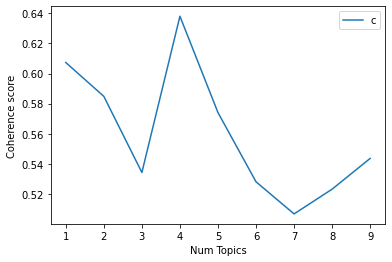

In [38]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=1, limit=10, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()